In [2]:
# %pip install torchvision torch tqdm pillow opencv-python matplotlib ipywidgets segmentation_models_pytorch scikit-learn

In [3]:
# !curl -L -o ../checkpoints/sam2.1_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt"

In [1]:

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys
from tqdm import tqdm

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
    
sys.path.insert(0, f"{os.path.abspath('')}/..")
from utils.logger import setup_folder_and_logger
experiment_folder, logger = setup_folder_and_logger(__name__)

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


## SAM Utils

In [2]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True, savepath=None):
    fig, axes = plt.subplots(1, len(masks), figsize=(10*len(masks), 10))
    
    # Handle single mask case
    if len(masks) == 1:
        axes = [axes]
    
    for i, (mask, score) in enumerate(zip(masks, scores)):
        axes[i].imshow(image)
        show_mask(mask, axes[i], borders=borders)
        
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, axes[i])
        
        if box_coords is not None:
            show_box(box_coords, axes[i])
        
        axes[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        axes[i].axis('off')
    
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath)
    else:
        plt.show()
    plt.close()

## Example image

Loading dataset...


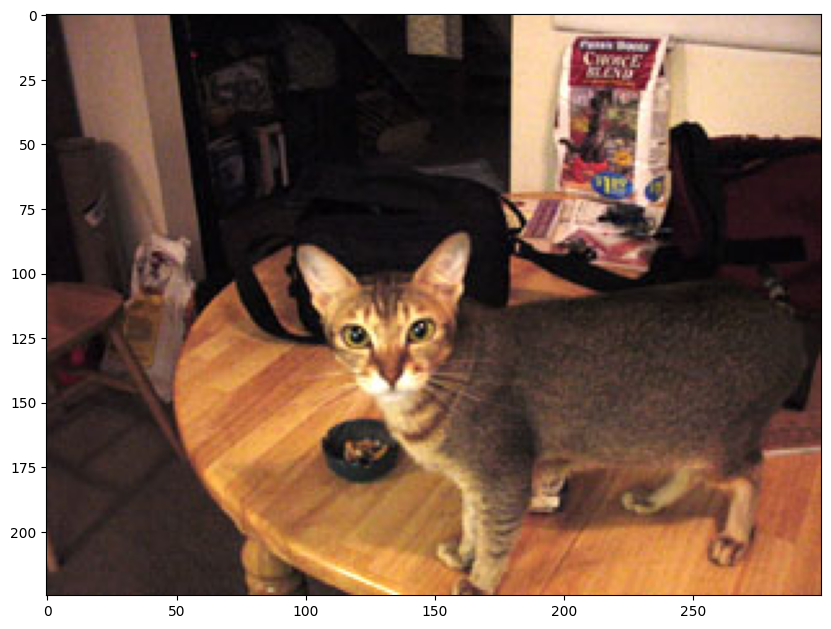

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader

# Load the dataset
print("Loading dataset...")
train_dataset = OxfordIIITPet(root='../data', 
                             split='trainval',
                             target_types=["category", "segmentation"],
                             download=True)

test_dataset = OxfordIIITPet(root='../data', 
                           split='test',
                           target_types=["category", "segmentation"],
                           download=True)

image = test_dataset[0][0]
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()


Total valid images with bounding boxes: 3671


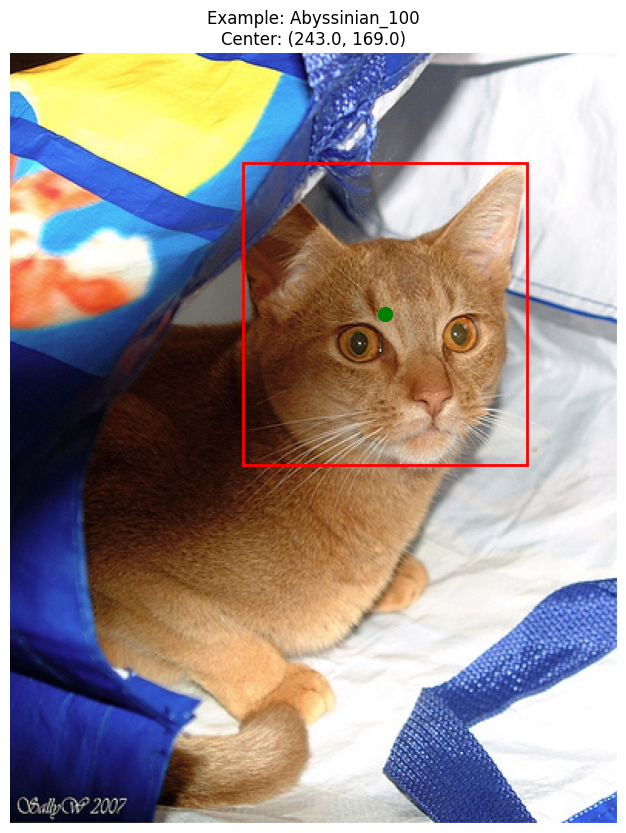

In [3]:
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import os
from PIL import Image
import numpy as np

# Read image names and skip header
with open('../data/oxford-iiit-pet/annotations/list.txt', 'r') as f:
    for _ in range(6):
        next(f)
    image_names = [line.split()[0] for line in f]

# Get valid images and their centers
valid_images = []
valid_centers = []

for img_name in image_names:
    xml_path = f'../data/oxford-iiit-pet/annotations/xmls/{img_name}.xml'
    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            bbox = tree.getroot().find('object/bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            valid_images.append(img_name)
            valid_centers.append([(xmin + xmax) / 2, (ymin + ymax) / 2])
        except Exception as e:
            continue

valid_centers = np.array(valid_centers)
print(f"Total valid images with bounding boxes: {len(valid_images)}")

# Show example image with bounding box and center
example_idx = 0
img = Image.open(f'../data/oxford-iiit-pet/images/{valid_images[example_idx]}.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(img)

# Get bounding box coordinates for visualization
tree = ET.parse(f'../data/oxford-iiit-pet/annotations/xmls/{valid_images[example_idx]}.xml')
bbox = tree.getroot().find('object/bndbox')
xmin, ymin = int(bbox.find('xmin').text), int(bbox.find('ymin').text)
xmax, ymax = int(bbox.find('xmax').text), int(bbox.find('ymax').text)

# Draw bounding box
rect = patches.Rectangle(
    (xmin, ymin), xmax - xmin, ymax - ymin,
    linewidth=2, edgecolor='r', facecolor='none'
)
plt.gca().add_patch(rect)

# Draw center point
plt.plot(valid_centers[example_idx][0], valid_centers[example_idx][1], 'go', markersize=10)
plt.title(f"Example: {valid_images[example_idx]}\nCenter: ({valid_centers[example_idx][0]:.1f}, {valid_centers[example_idx][1]:.1f})")
plt.axis('off')
plt.show()

### Load and test SAM

Samples a single point

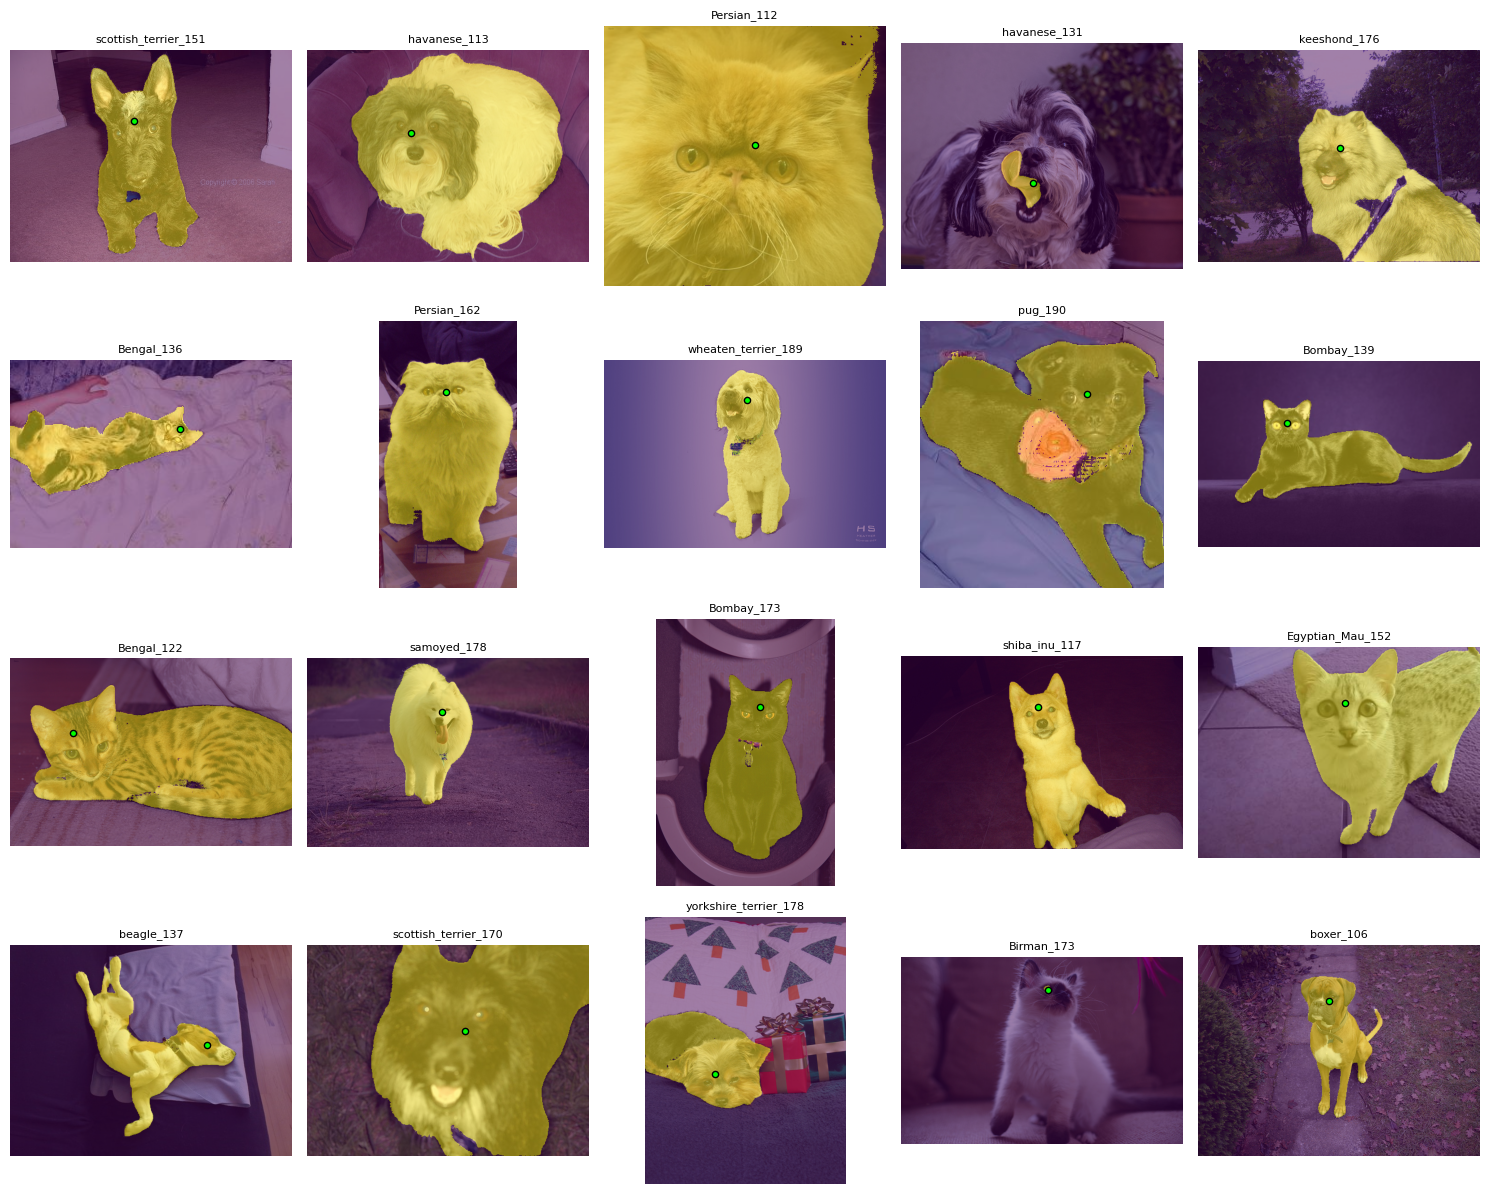

In [4]:
import sys
sys.path.insert(0, '/workspace/ADL-group-project/weakly_supervised/sam2')
sys.path.insert(0, f"{os.path.abspath('')}/sam2")

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize SAM
sam2_model = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml", 
                        "./models/sam2.1_hiera_large.pt", 
                        device=device)
predictor = SAM2ImagePredictor(sam2_model)

# Create grid
grid_rows, grid_cols = 4, 5
sample_size = grid_rows * grid_cols
indices = np.random.choice(len(valid_images), sample_size, replace=False)

fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 12))

# Process images
for ax, idx in zip(axs.flat, indices):
    try:
        # Load and process image
        img = Image.open(f'../data/oxford-iiit-pet/images/{valid_images[idx]}.jpg')
        img_np = np.array(img)
        predictor.set_image(img_np)

        # Get mask prediction
        center_point = valid_centers[idx].reshape(1, -1)
        masks, scores, _ = predictor.predict(
            point_coords=center_point,
            point_labels=np.array([1]),
            multimask_output=False
        )

        # Display result
        ax.imshow(img_np)
        ax.imshow(masks[0], alpha=0.5)
        ax.scatter(center_point[:, 0], center_point[:, 1], c='lime', s=20, edgecolors='black')
        ax.set_title(valid_images[idx], fontsize=8)
        ax.axis('off')

    except Exception as e:
        ax.axis('off')
        print(f"Error processing {valid_images[idx]}: {str(e)}")

plt.tight_layout()
plt.show()

### Segment with 3-points

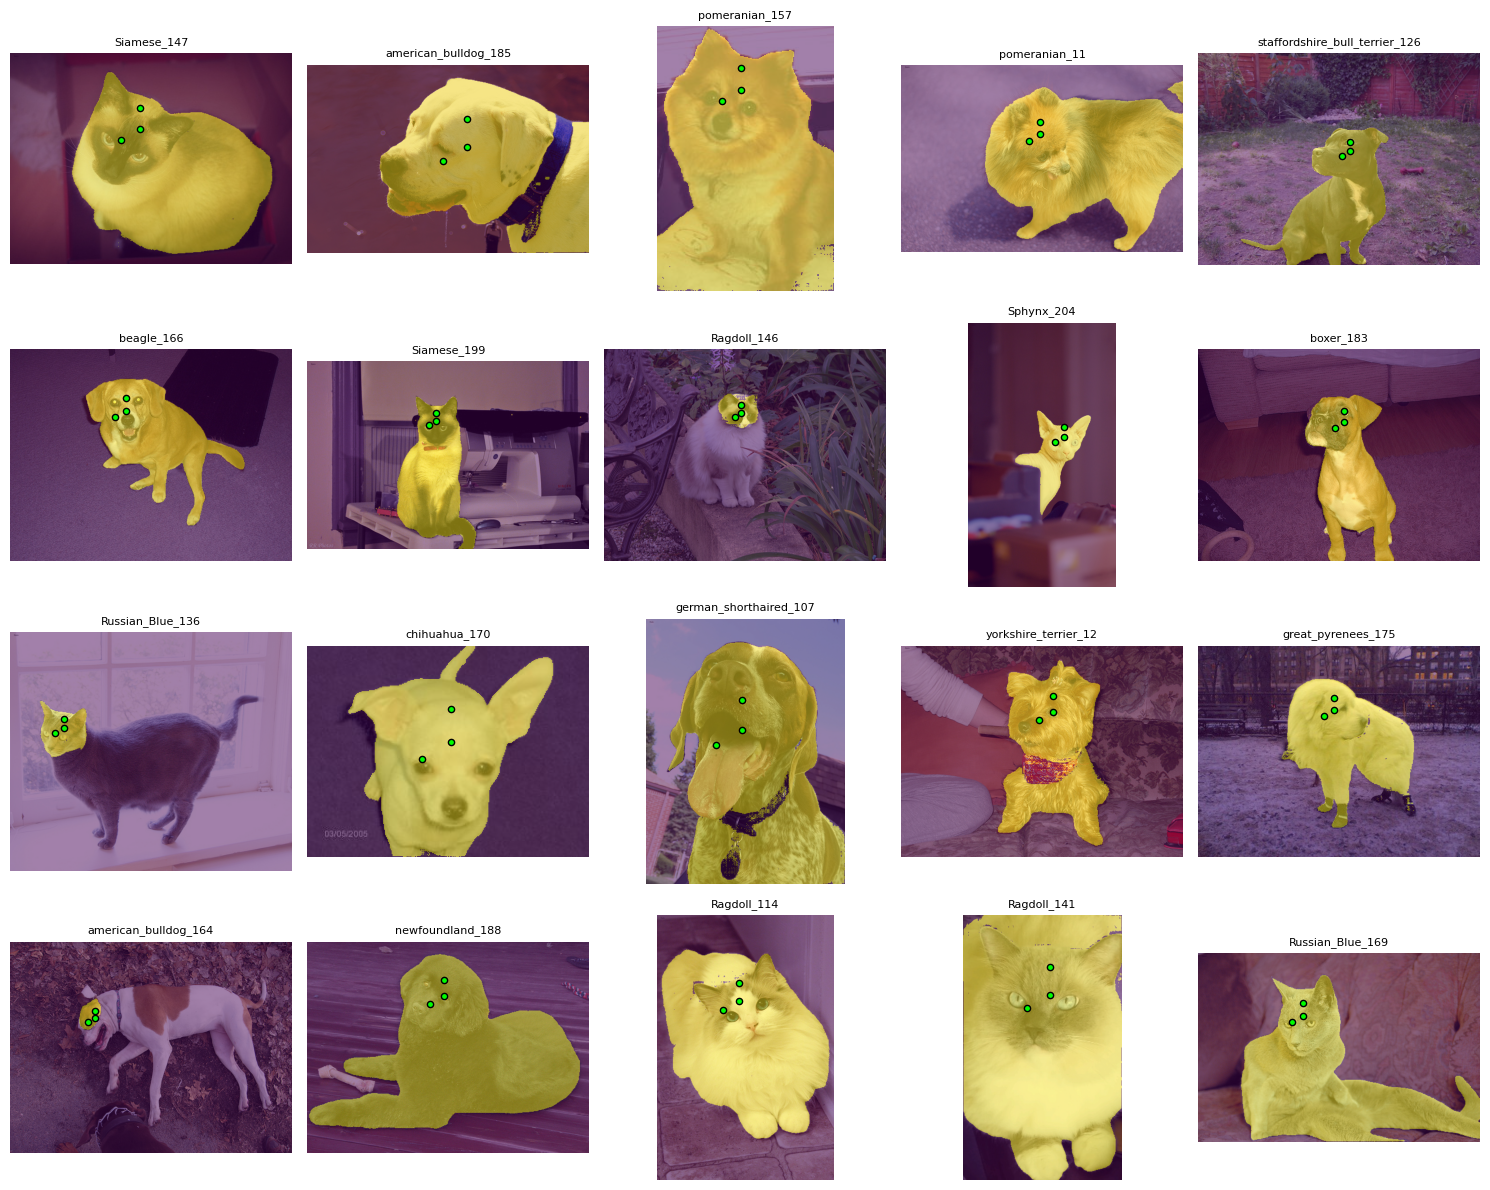

In [5]:
import matplotlib.pyplot as plt
import math

# Parameters
grid_rows, grid_cols = 4, 5
sample_size = grid_rows * grid_cols
indices = np.random.choice(len(valid_images), sample_size, replace=False)

# Helper to compute top and bottom-left triangle vertices from center, proportionally
def get_two_triangle_vertices(center, bbox):
    cx, cy = center
    xmin, ymin, xmax, ymax = bbox

    box_width = xmax - xmin
    box_height = ymax - ymin
    r = 0.2 * min(box_width, box_height)  # 20% of the shorter side

    # Angles: 90 (top), 210 (bottom-left)
    angles = [90, 210]
    angle_rad = [math.radians(a) for a in angles]

    points = [(cx + r * math.cos(a), cy - r * math.sin(a)) for a in angle_rad]
    return np.array(points)

# Create figure
fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 12))

for ax, idx in zip(axs.flat, indices):
    try:
        img = Image.open(f'../data/oxford-iiit-pet/images/{valid_images[idx]}.jpg')
        img_np = np.array(img)
        predictor.set_image(img_np)

        xml_path = f'../data/oxford-iiit-pet/annotations/xmls/{valid_images[idx]}.xml'
        tree = ET.parse(xml_path)
        bbox_elem = tree.getroot().find('object/bndbox')
        xmin = int(bbox_elem.find('xmin').text)
        ymin = int(bbox_elem.find('ymin').text)
        xmax = int(bbox_elem.find('xmax').text)
        ymax = int(bbox_elem.find('ymax').text)

        center_point = np.array([(xmin + xmax) / 2, (ymin + ymax) / 2])
        extra_points = get_two_triangle_vertices(center_point, (xmin, ymin, xmax, ymax))

        all_points = np.vstack([center_point, extra_points])
        labels = np.ones(len(all_points), dtype=int)

        # Get mask prediction
        masks, scores, _ = predictor.predict(
            point_coords=all_points,
            point_labels=labels,
            multimask_output=False
        )

        # Overlay mask and points on image
        ax.imshow(img_np)
        ax.imshow(masks[0], alpha=0.5)
        ax.scatter(all_points[:, 0], all_points[:, 1], c='lime', s=20, edgecolors='black')
        ax.set_title(valid_images[idx], fontsize=8)
        ax.axis('off')

    except Exception as e:
        ax.axis('off')
        print(f"Error processing {valid_images[idx]}: {str(e)}")

plt.tight_layout()
plt.show()

### Full batch SAM single 

mode = 'center' OR 'triangle3'

change 'save_name' to prevent copying over saved files with the same name 

In [6]:
import os
import math
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# === CONFIG ===
mode = 'center'  # Options: 'center' or 'triangle3'
save_name = "single-point-sam" if mode == 'center' else "triangle3-point-sam"
output_dir = './sam_masks'
os.makedirs(output_dir, exist_ok=True)

# === SAM PROCESSING ===
sample_size = int(len(valid_images) * 1)
selected_indices = np.random.choice(len(valid_images), sample_size, replace=False)

all_masks = []
all_scores = []
processed_names = []

print(f"Processing {sample_size} images using mode '{mode}'...")

for idx in tqdm(selected_indices):
    try:
        # Load image
        img = Image.open(f'../data/oxford-iiit-pet/images/{valid_images[idx]}.jpg')
        predictor.set_image(np.array(img))

        if mode == 'center':
            point_coords = valid_centers[idx].reshape(1, -1)
            point_labels = np.array([1])
        
        elif mode == 'triangle3':
            xml_path = f'../data/oxford-iiit-pet/annotations/xmls/{valid_images[idx]}.xml'
            tree = ET.parse(xml_path)
            bbox_elem = tree.getroot().find('object/bndbox')
            xmin = int(bbox_elem.find('xmin').text)
            ymin = int(bbox_elem.find('ymin').text)
            xmax = int(bbox_elem.find('xmax').text)
            ymax = int(bbox_elem.find('ymax').text)

            center_point = np.array([(xmin + xmax) / 2, (ymin + ymax) / 2])

            # Triangle radius proportional to box size
            box_width = xmax - xmin
            box_height = ymax - ymin
            r = 0.2 * min(box_width, box_height)

            angles = [90, 210]  # top and bottom-left
            angle_rad = [math.radians(a) for a in angles]
            extra_points = np.array([
                (center_point[0] + r * math.cos(a), center_point[1] - r * math.sin(a))
                for a in angle_rad
            ])
            point_coords = np.vstack([center_point, extra_points])
            point_labels = np.ones(len(point_coords), dtype=int)

        # Get mask prediction
        masks, scores, _ = predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False
        )

        # Store results
        all_masks.append(masks[0])
        all_scores.append(scores[0])
        processed_names.append(valid_images[idx])

        # Show visualization every 300
        if len(all_masks) % 300 == 0:
            print(f"\nProcessed {len(all_masks)} images")
            print(f"Current average score: {np.mean(all_scores):.3f}")
            show_masks(
                np.array(img),
                masks,
                scores,
                point_coords=point_coords,
                input_labels=point_labels,
                borders=True
            )
            plt.close()

    except Exception as e:
        print(f"\nError processing {valid_images[idx]}: {str(e)}")

# Save results
save_path = f'{output_dir}/{save_name}.npy'
if os.path.exists(save_path):
    override = input(f"File {save_name}.npy already exists. Override? (y/n): ").lower()
    if override != 'y':
        print("Operation cancelled")
        exit()

results = {
    'masks': np.array(all_masks, dtype=object),
    'scores': np.array(all_scores),
    'image_names': np.array(processed_names)
}
np.save(save_path, results)

print("\nProcessing complete!")
print(f"Total images processed: {len(processed_names)}")
print(f"Final average score: {np.mean(all_scores):.3f}")

Processing 3671 images using mode 'center'...


  0%|          | 17/3671 [00:16<58:14,  1.05it/s] 


KeyboardInterrupt: 